# CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [5]:
!pip install --upgrade pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *

install_requirements(chapter=6)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.41.2
Using datasets v2.20.0
Using accelerate v0.31.0
Using sentencepiece v0.1.99
Using sacrebleu v2.4.2
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.21.0
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


In [2]:
!pip install evaluate

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import evaluate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
rouge_metric = evaluate.load("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [1]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [3]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [9]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.387456,0.170271,0.247076,0.354666


In [10]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]
        #이 함수가 호출 될때마다 yield 안에 변수를 리턴해줌

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        #토크나이저로 인풋 정리, 최대 길이지정, truncation으로 길면 잘라버림 , padding으로 짧으면 pad붙임
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128) #앞에서 배운대로 길이 패널티 주고, 빔 서치 8개로 하고, 출력의 최대 길이 지정

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries] #<n> 이 줄넘김인데 공백으로 바꿈
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(rouge_dict, index=["pegasus"])

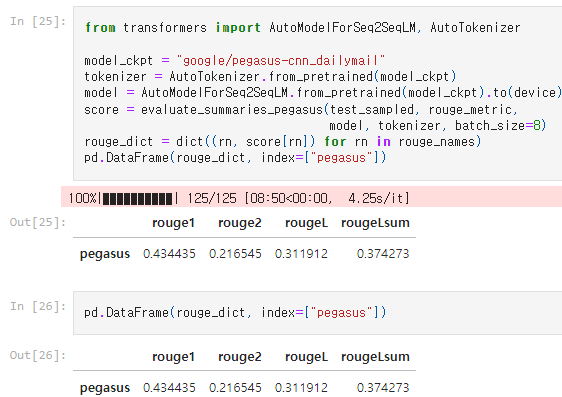

위에 코드가 너무 메모리를 잡아먹어서 RAM이 부족하다고 뜸 그래서 결과를 사진으로 대신 작성  
페가수스 모델의 rouge 손실을 계산해서 보여줌

In [4]:
from datasets import load_dataset
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [7]:
from transformers import pipeline
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

In [8]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))


요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


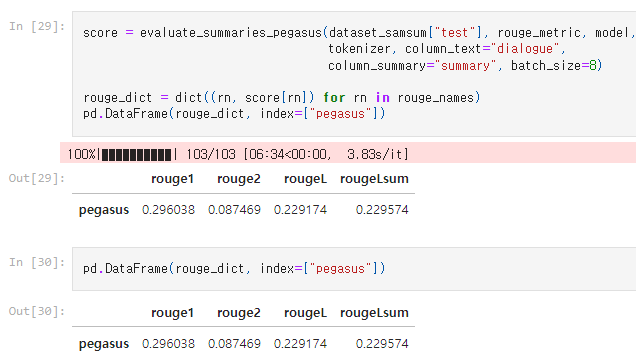

여기도 동일하게 메모리 초과 나오니까 사진으로 대신 함  
rouge 손실 계산하니 나쁘지 않음 여기서 미세 튜닝을 진행해 rouge 점수 높이기

In [10]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

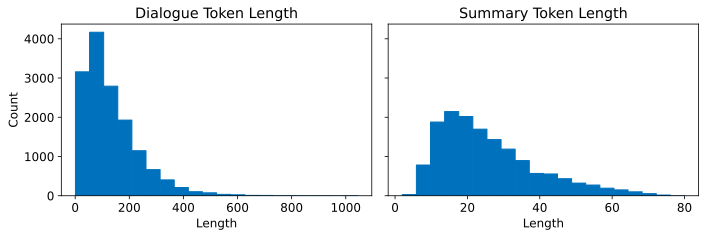

In [11]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [13]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    #with tokenizer.as_target_tokenizer(): 이 함수 기능이 타겟이 있는 데이터의 경우 타겟 언어에 맞게 토크나이저를 해야되서 이 함수를 실행해야 했음
    #하지만 버전이 계속 업데이트 되면서 밑에 토크나이저 함수 안에 text_target 라는 인수에다가 타겟을 넣어주면 똑같이 작동함
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=128,
                                    truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [15]:
import pandas as pd
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')
#디코더 label은 인풋에서 한 스텝 앞의 단어가 됨 뭐 마스크로 가려버리니까 상관 없을듯?

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [18]:
from transformers import DataCollatorForSeq2Seq
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
#위에 과정을 이 함수가 알아서 처리해줌

In [19]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()
'''score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])'''
#evaluate_summaries_pegasus 이 함수가 메모리 초과의 주된 원인이라 함수 들어가는건 전부 사진으로 대처

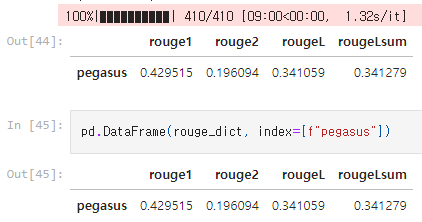

내가 위에서 rouge "손실" 이라고 계속 사용해서 내 머리속에 에러가 생김   
rouge "점수"이므로 높을 수록 좋은 것  
미세튜닝하고 점수가 올라갔으니 성능이 개선 된 것을 의미함



In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="haesun/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

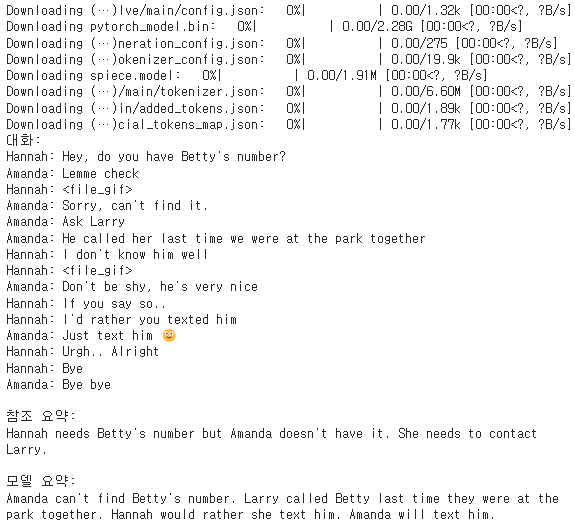

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

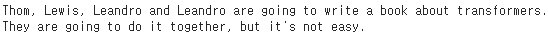

#결론

텍스트 요약은 앞에서 진행한분류 작업에 비해 특수한 어려움이 있습니다.  
정확도 같은 지표를 생성된 텍스트에 적용하지 못합니다. 따라서 새로운 평가 지표가 필요합니다.  
여기서는 BLEU와 ROUGE 지표를 소개 했지만 결국 사람의 판단이 가장 좋은 척도입니다.  